In [1]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import os, sys
parent_dir = os.path.abspath('../../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from functions.exploratory_analysis import create_scatter_plots_grid
from functions.pooled_ols import create_balanced_panel, regression_model_statsmodels, regression_model_linearmodels, analyze_regression_results, analyze_linearmodels_regression_results

In [2]:
foundational_df_no_transformations = pd.read_csv('output/foundational_no_transformations.csv')
foundational_df_transformed = pd.read_csv('output/foundational_transformed.csv')
foundational_df_no_transformations_accounts = pd.read_csv('output/foundational_no_transformations_accounts.csv')
foundational_df_transformed_accounts = pd.read_csv('output/foundational_transformed_accounts.csv')

Check if the data set is balanced

Is the dataset balanced? False
Total number of observations: 131


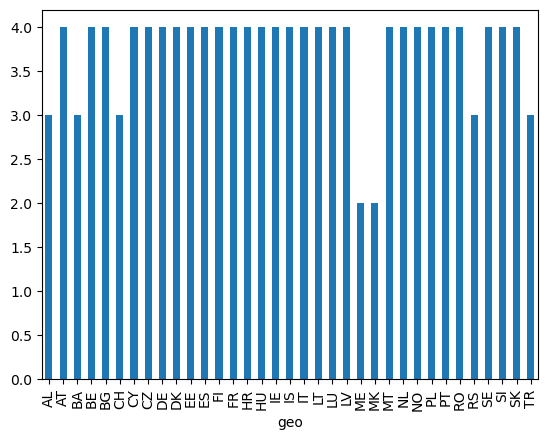

In [3]:
counts = foundational_df_transformed.groupby('geo')['TIME_PERIOD'].count()
counts.plot(kind='bar')
is_balanced = counts.nunique() == 1
print("Is the dataset balanced?", is_balanced)
total_observations = foundational_df_transformed.shape[0]
print("Total number of observations:", total_observations)

Same for accounts data

Is the dataset balanced? False
Total number of observations: 880


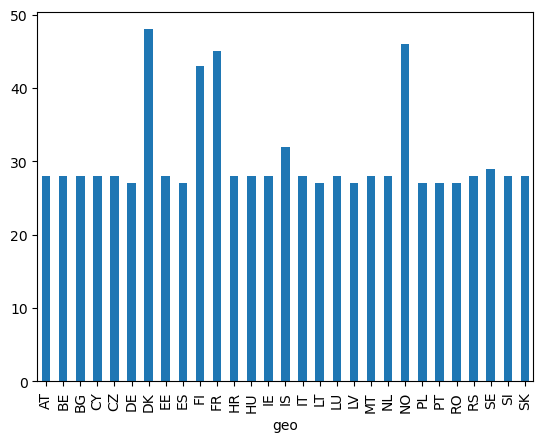

In [4]:
counts_accounts = foundational_df_transformed_accounts.groupby('geo')['TIME_PERIOD'].count()
counts_accounts.plot(kind='bar')
is_balanced_accounts = counts_accounts.nunique() == 1
print("Is the dataset balanced?", is_balanced_accounts)
total_observations_accounts = foundational_df_transformed_accounts.shape[0]
print("Total number of observations:", total_observations_accounts)

<Axes: xlabel='TIME_PERIOD'>

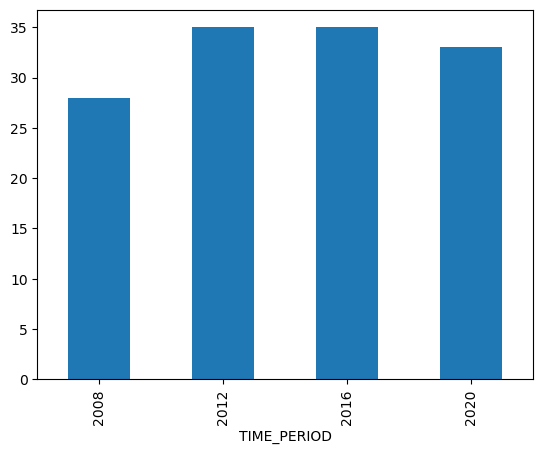

In [5]:
counts_by_year = foundational_df_transformed.groupby('TIME_PERIOD')['geo'].count()
counts_by_year.plot(kind='bar')

Same for accounts data

<Axes: xlabel='TIME_PERIOD'>

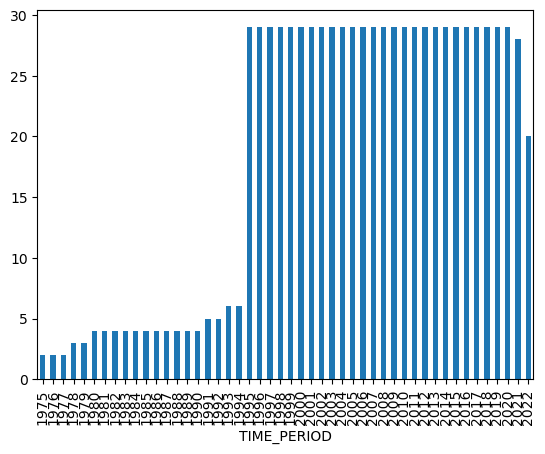

In [6]:
counts_by_year_accounts = foundational_df_transformed_accounts.groupby('TIME_PERIOD')['geo'].count()
counts_by_year_accounts.plot(kind='bar')

Only keep years with most observations. 
Balance the dataset by removing countries that don't have data for selected years.

In [7]:
time_periods = [2012, 2016, 2020]
time_periods_accounts = [year for year in range(1995, 2020)]
foundational_df_transformed_balanced = create_balanced_panel(foundational_df_transformed, time_periods)
foundational_df_balanced_no_transformations = create_balanced_panel(foundational_df_no_transformations, time_periods)
foundational_df_transformed_balanced_accounts = create_balanced_panel(foundational_df_transformed_accounts, time_periods_accounts)
foundational_df_balanced_no_transformations_accounts = create_balanced_panel(foundational_df_no_transformations_accounts, time_periods_accounts)

Is the dataset balanced? True
Total number of observations: 99
Number of unique countries: 33


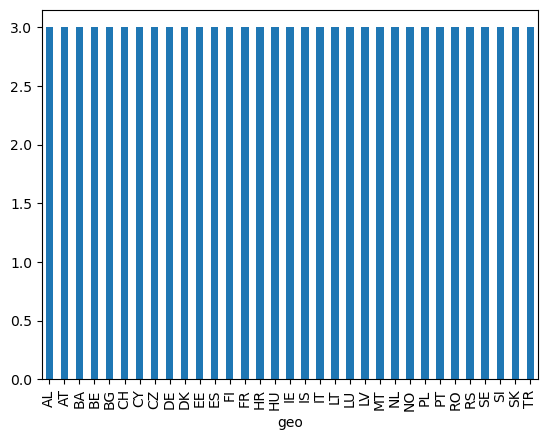

In [8]:
counts = foundational_df_transformed_balanced.groupby('geo')['TIME_PERIOD'].count()
counts.plot(kind='bar')
is_balanced = counts.nunique() == 1
print("Is the dataset balanced?", is_balanced)
total_observations = foundational_df_transformed_balanced.shape[0]
print("Total number of observations:", total_observations)
print("Number of unique countries:", foundational_df_transformed_balanced['geo'].nunique())

Is the dataset balanced? True
Total number of observations: 725
Number of unique countries: 29


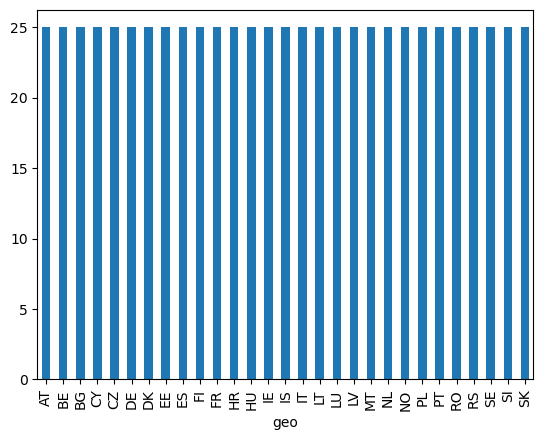

In [9]:
counts_accounts = foundational_df_transformed_balanced_accounts.groupby('geo')['TIME_PERIOD'].count()
counts_accounts.plot(kind='bar')
is_balanced_accounts = counts_accounts.nunique() == 1
print("Is the dataset balanced?", is_balanced_accounts)
total_observations_accounts = foundational_df_transformed_balanced_accounts.shape[0]
print("Total number of observations:", total_observations_accounts)
print("Number of unique countries:", foundational_df_transformed_balanced_accounts['geo'].nunique())

Values from the StandardScaler used to transform the data (not used now but could be useful e.g for plots?)

In [10]:
scaler_df = pd.read_csv('output/scaler_values.csv')
energy_scale = scaler_df.loc[scaler_df['variable'] == 'energy', 'scale'].values[0]
energy_mean = scaler_df.loc[scaler_df['variable'] == 'energy', 'mean'].values[0]

## Hypothesis

The higher the share of employment/labor in the Foundational sector of the economy (Material or Providential), the higher the chance that related needs could be met at a low level of energy use

## Key assumptions and parameters (TBD)

For now just a p-value, might add more constants here later

In [11]:
assumptions = {'p_value_threshold': 0.05}

## Removing outliers

In [12]:
create_scatter_plots_grid(foundational_df_no_transformations, 'TIME_PERIOD', ['overlooked', 'material', 'providential', 'other'], time_periods)

Same for accounts data

In [13]:
foundational_df_no_transformations_accounts_selected_years = foundational_df_no_transformations_accounts[foundational_df_no_transformations_accounts['TIME_PERIOD'].isin(time_periods_accounts)]
foundational_df_no_transformations_accounts
create_scatter_plots_grid(foundational_df_no_transformations_accounts_selected_years, 'TIME_PERIOD', ['overlooked', 'material', 'providential', 'other'], time_periods_accounts)

Based on visual inspection, LU 2008, AL 2016, AL 2020, TR 2016, IS 2008, MT 2012 are outliers for labour cost survey, and EE 1996, LV 2001, 2004, 2008, 2009, 2010, 2014,2017 (Basically just Latvia) for accounts.

Providential data looks suspicious in general in the accounts dataset, but let's roll with it for now.

In [14]:
outliers_to_remove = [{'geo': 'LU', 'TIME_PERIOD': 2008}, {'geo': 'AL', 'TIME_PERIOD': 2016}, {'geo': 'AL', 'TIME_PERIOD': 2020}, {'geo': 'TR', 'TIME_PERIOD': 2016}, {'geo': 'IS', 'TIME_PERIOD': 2008}, {'geo': 'MT', 'TIME_PERIOD': 2012}]
outliers_to_remove_accounts = [{'geo': 'EE', 'TIME_PERIOD': 1996}, {'geo': 'EE', 'TIME_PERIOD': 2019}]

foundational_df_transformed_no_outliers = foundational_df_transformed_balanced.copy()
foundational_df_no_transformations_no_outliers = foundational_df_balanced_no_transformations.copy()
foundational_df_transformed_no_outliers_accounts = foundational_df_transformed_balanced_accounts.copy()
foundational_df_no_transformations_no_outliers_accounts = foundational_df_balanced_no_transformations_accounts.copy()

for outlier in outliers_to_remove:
    foundational_df_transformed_no_outliers = foundational_df_transformed_no_outliers[~((foundational_df_transformed_no_outliers['geo'] == outlier['geo']) & (foundational_df_transformed_no_outliers['TIME_PERIOD'] == outlier['TIME_PERIOD']))]
    foundational_df_no_transformations_no_outliers = foundational_df_no_transformations_no_outliers[foundational_df_no_transformations_no_outliers['geo'] != 'LV']

for outlier in outliers_to_remove_accounts:
    foundational_df_transformed_no_outliers_accounts = foundational_df_transformed_no_outliers_accounts[~((foundational_df_transformed_no_outliers_accounts['geo'] == outlier['geo']) & (foundational_df_transformed_no_outliers_accounts['TIME_PERIOD'] == outlier['TIME_PERIOD']))]
    foundational_df_no_transformations_no_outliers_accounts = foundational_df_no_transformations_no_outliers_accounts[~((foundational_df_no_transformations_no_outliers_accounts['geo'] == outlier['geo']) & (foundational_df_no_transformations_no_outliers_accounts['TIME_PERIOD'] == outlier['TIME_PERIOD']))]


foundational_df_transformed_no_outliers_accounts = foundational_df_transformed_no_outliers_accounts[foundational_df_transformed_no_outliers_accounts['geo'] != 'LV']
foundational_df_no_transformations_no_outliers_accounts = foundational_df_no_transformations_no_outliers_accounts[foundational_df_no_transformations_no_outliers_accounts['geo'] != 'LV']
    
print('Number of rows in foundational_df_transformed_balanced: {}'.format(len(foundational_df_transformed_balanced)))
print('Number of rows in foundational_df_transformed_no_outliers: {}'.format(len(foundational_df_transformed_no_outliers)))
print('Number of rows in foundational_df_no_transformations_no_outliers: {}'.format(len(foundational_df_no_transformations_no_outliers))
)
print('Number of rows in foundational_df_transformed_balanced_accounts: {}'.format(len(foundational_df_transformed_balanced_accounts)))
print('Number of rows in foundational_df_transformed_no_outliers_accounts: {}'.format(len(foundational_df_transformed_no_outliers_accounts)))
print('Number of rows in foundational_df_no_transformations_no_outliers_accounts: {}'.format(len(foundational_df_no_transformations_no_outliers_accounts))
)

Number of rows in foundational_df_transformed_balanced: 99
Number of rows in foundational_df_transformed_no_outliers: 95
Number of rows in foundational_df_no_transformations_no_outliers: 96
Number of rows in foundational_df_transformed_balanced_accounts: 725
Number of rows in foundational_df_transformed_no_outliers_accounts: 698
Number of rows in foundational_df_no_transformations_no_outliers_accounts: 698


Plot after removing outliers

In [15]:
foundational_df_no_transformations_no_outliers_accounts_selected_years = foundational_df_no_transformations_no_outliers_accounts[foundational_df_no_transformations_no_outliers_accounts['TIME_PERIOD'].isin(time_periods_accounts)]
create_scatter_plots_grid(foundational_df_no_transformations_no_outliers_accounts_selected_years, 'TIME_PERIOD', ['overlooked', 'material', 'providential', 'other'], time_periods_accounts)

## Reproducing JV analysis with new data

This is the function used to conduct Pooled OLS regressions throughout the analysis. It:
1) Subsets the full data frame by given variables
2) Removes inf and nan values
3) Only keeps rows where data is available for both x and y variables
4) Fits a Pooled OLS regression with the given x and y variables

In [16]:
regression_df = foundational_df_transformed_balanced.copy()
regression_df_accounts = foundational_df_transformed_balanced_accounts.copy()
regression_df_no_outliers = foundational_df_transformed_no_outliers.copy()
regression_df_no_outliers_accounts = foundational_df_transformed_no_outliers_accounts.copy()

### Bivariate regressions

$$
  \widetilde{NS}_i = a + b \widetilde{ENU}_i + e_i
$$

Except in our case it's a pooled OLS, since we have a panel dataset.

In [17]:
bivariate_regressions = []
bivariate_regressions_accounts = []
regression_df_no_outliers_no_na_bivariate = regression_df_no_outliers.dropna(subset=['hale', 'energy'])
regression_df_no_outliers_accounts_no_na_bivariate = regression_df_no_outliers_accounts.dropna(subset=['hale', 'energy'])

First plot the data to see if there is a linear relationship

<Axes: xlabel='energy', ylabel='hale'>

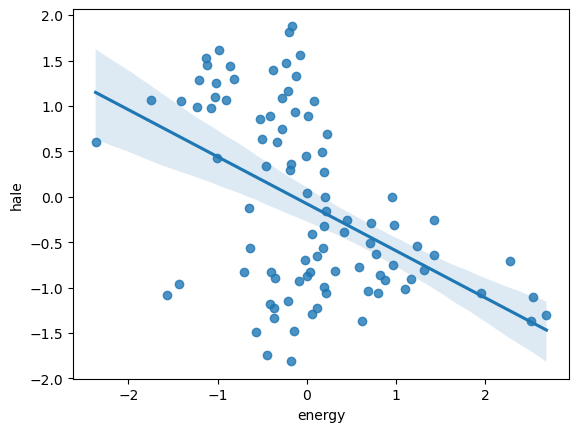

In [18]:
sns.regplot(data=regression_df_no_outliers_no_na_bivariate, x='energy', y='hale')

In [19]:
y_variables = ['hale', 'education', 'socialsupport']
x_variables = ['overlooked', 'material', 'providential', 'other']

In [20]:
for y_variable in y_variables:
    pooled_ols_bivariate = regression_model_statsmodels(regression_df_no_outliers_no_na_bivariate, y_variable, ['energy'], 'pooled_ols')
    bivariate_regressions.append({'model': pooled_ols_bivariate, 'name': 'Pooled OLS Bivariate', 'data': regression_df_no_outliers_no_na_bivariate, 'dependent_variable': y_variable, 'independent_variables': ['energy'], 'goodness_of_fit': analyze_regression_results(pooled_ols_bivariate, assumptions, "Pooled OLS Bivariate")})
    pooled_ols_bivariate_linearmodels = regression_model_linearmodels(regression_df_no_outliers_no_na_bivariate, y_variable, ['energy'], 'pooled_ols')
    bivariate_regressions.append({'model': pooled_ols_bivariate_linearmodels, 'name': 'Pooled OLS Bivariate linearmodels', 'data': regression_df_no_outliers_no_na_bivariate, 'dependent_variable': y_variable, 'independent_variables': ['energy'], 'goodness_of_fit': analyze_linearmodels_regression_results(pooled_ols_bivariate_linearmodels, assumptions, "Pooled OLS Bivariate", regression_df_no_outliers_no_na_bivariate['energy'])})
    fixed_effects_bivariate = regression_model_statsmodels(regression_df_no_outliers_no_na_bivariate, y_variable, ['energy'], 'fixed_effects')
    bivariate_regressions.append({'model': fixed_effects_bivariate, 'name': 'Fixed Effects Bivariate', 'data': regression_df_no_outliers_no_na_bivariate, 'dependent_variable': y_variable, 'independent_variables': ['energy'], 'goodness_of_fit': analyze_regression_results(fixed_effects_bivariate, assumptions, "Fixed Effects Bivariate")})
    fixed_effects_bivariate_linearmodels = regression_model_linearmodels(regression_df_no_outliers_no_na_bivariate, y_variable, ['energy'], 'fixed_effects')
    bivariate_regressions.append({'model': fixed_effects_bivariate_linearmodels, 'name': 'Fixed Effects Bivariate linearmodels', 'data': regression_df_no_outliers_no_na_bivariate, 'dependent_variable': y_variable, 'independent_variables': ['energy'], 'goodness_of_fit': analyze_linearmodels_regression_results(fixed_effects_bivariate_linearmodels, assumptions, "Fixed Effects Bivariate", regression_df_no_outliers_no_na_bivariate['energy'], 'fixed_effects')})
    random_effects_bivariate = regression_model_statsmodels(regression_df_no_outliers_no_na_bivariate, y_variable, ['energy'], 'random_effects')
    bivariate_regressions.append({'model': random_effects_bivariate, 'name': 'Random Effects Bivariate', 'data': regression_df_no_outliers_no_na_bivariate, 'dependent_variable': y_variable, 'independent_variables': ['energy'], 'goodness_of_fit': analyze_regression_results(random_effects_bivariate, assumptions, "Random Effects Bivariate")})
    random_effects_bivariate_linearmodels = regression_model_linearmodels(regression_df_no_outliers_no_na_bivariate, y_variable, ['energy'], 'random_effects')
    bivariate_regressions.append({'model': random_effects_bivariate_linearmodels, 'name': 'Random Effects Bivariate linearmodels', 'data': regression_df_no_outliers_no_na_bivariate, 'dependent_variable': y_variable, 'independent_variables': ['energy'], 'goodness_of_fit': analyze_linearmodels_regression_results(random_effects_bivariate_linearmodels, assumptions, "Random Effects Bivariate", regression_df_no_outliers_no_na_bivariate['energy'])})
# optional QQ plots
# for reg in bivariate_regressions:
#     fig = sm.qqplot(data=reg.resid, line='45')
#     fig.suptitle('QQ plot for residuals of regression of {} on {} (labour cost survey)'.format('hale', ['energy']))

/Users/supernaturval/Documents/GitHub/provisioning-model/provisioning_model/functions/pooled_ols.py:255: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/supernaturval/Documents/GitHub/provisioning-model/provisioning_model/functions/pooled_ols.py:261: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/supernaturval/Documents/GitHub/provisioning-model/provisioning_model/functions/pooled_ols.py:274: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the cave

Same with accounts data

Plot to see if the relationship is linear

<Axes: xlabel='energy', ylabel='hale'>

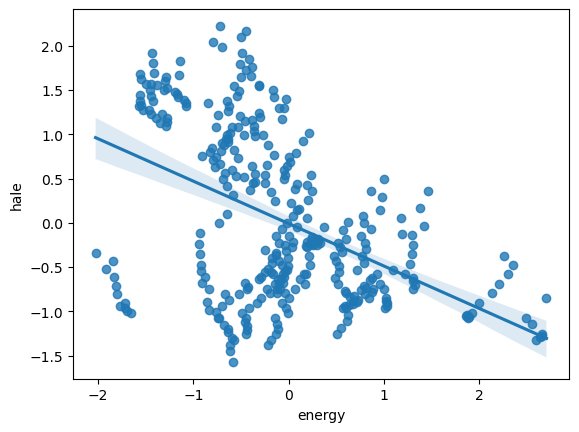

In [21]:
sns.regplot(data=regression_df_no_outliers_accounts_no_na_bivariate, x='energy', y='hale')

That's a bit crowded, maybe if we plot for one year?

<Axes: xlabel='energy', ylabel='hale'>

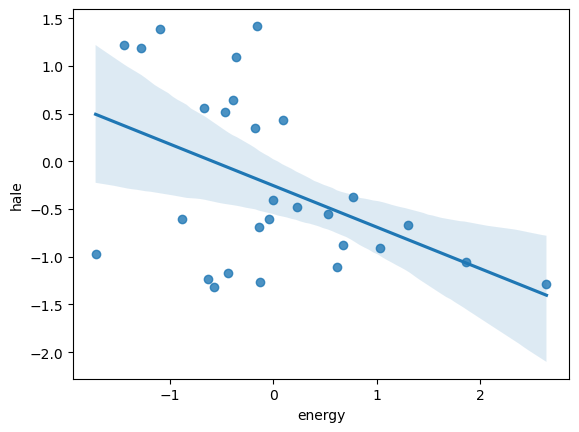

In [22]:
# filter for year 2017
regression_df_no_outliers_accounts_no_na_bivariate_2017 = regression_df_no_outliers_accounts_no_na_bivariate[regression_df_no_outliers_accounts_no_na_bivariate['TIME_PERIOD'] == 2017]
sns.regplot(data=regression_df_no_outliers_accounts_no_na_bivariate_2017, x='energy', y='hale')

Doesn't look quite linear...

In [23]:
for y_variable in y_variables:
    pooled_ols_bivariate_accounts = regression_model_statsmodels(regression_df_no_outliers_accounts_no_na_bivariate, y_variable, ['energy'], 'pooled_ols')
    bivariate_regressions_accounts.append({'model': pooled_ols_bivariate_accounts, 'name': 'Pooled OLS Bivariate Accounts', 'data': regression_df_no_outliers_accounts_no_na_bivariate, 'dependent_variable': y_variable, 'independent_variables': ['energy'], 'goodness_of_fit': analyze_regression_results(pooled_ols_bivariate_accounts, assumptions, "Pooled OLS Bivariate")})
    pool_ols_bivariate_accounts_linearmodels = regression_model_linearmodels(regression_df_no_outliers_accounts_no_na_bivariate, y_variable, ['energy'], 'pooled_ols')
    bivariate_regressions_accounts.append({'model': pool_ols_bivariate_accounts_linearmodels, 'name': 'Pooled OLS Bivariate Accounts linearmodels', 'data': regression_df_no_outliers_accounts_no_na_bivariate, 'dependent_variable': y_variable, 'independent_variables': ['energy']})
    fixed_effects_bivariate_accounts = regression_model_statsmodels(regression_df_no_outliers_accounts_no_na_bivariate, y_variable, ['energy'], 'fixed_effects')
    bivariate_regressions_accounts.append({'model': fixed_effects_bivariate_accounts, 'name': 'Fixed Effects Bivariate Accounts', 'data': regression_df_no_outliers_accounts_no_na_bivariate, 'dependent_variable': y_variable, 'independent_variables': ['energy'], 'goodness_of_fit': analyze_regression_results(fixed_effects_bivariate_accounts, assumptions, "Fixed Effects Bivariate")})
    fixed_effects_bivariate_accounts_linearmodels = regression_model_linearmodels(regression_df_no_outliers_accounts_no_na_bivariate, y_variable, ['energy'], 'fixed_effects')
    bivariate_regressions_accounts.append({'model': fixed_effects_bivariate_accounts_linearmodels, 'name': 'Fixed Effects Bivariate linearmodels Accounts linearmodels', 'data': regression_df_no_outliers_accounts_no_na_bivariate, 'dependent_variable': y_variable, 'independent_variables': ['energy'], 'goodness_of_fit': analyze_linearmodels_regression_results(fixed_effects_bivariate_accounts_linearmodels, assumptions, "Fixed Effects Bivariate", regression_df_no_outliers_accounts_no_na_bivariate['energy'], 'fixed_effects')})
    random_effects_bivariate_accounts = regression_model_statsmodels(regression_df_no_outliers_accounts_no_na_bivariate, y_variable, ['energy'], 'random_effects')
    bivariate_regressions_accounts.append({'model': random_effects_bivariate_accounts, 'name': 'Random Effects Bivariate Accounts', 'data': regression_df_no_outliers_accounts_no_na_bivariate, 'dependent_variable': y_variable, 'independent_variables': ['energy'], 'goodness_of_fit': analyze_regression_results(random_effects_bivariate_accounts, assumptions, "Random Effects Bivariate")})
    random_effects_bivariate_accounts_linearmodels = regression_model_linearmodels(regression_df_no_outliers_accounts_no_na_bivariate, y_variable, ['energy'], 'random_effects')
    bivariate_regressions_accounts.append({'model': random_effects_bivariate_accounts_linearmodels, 'name': 'Random Effects Bivariate Accounts linearmodels', 'data': regression_df_no_outliers_accounts_no_na_bivariate, 'dependent_variable': y_variable, 'independent_variables': ['energy'], 'goodness_of_fit': analyze_linearmodels_regression_results(random_effects_bivariate_accounts_linearmodels, assumptions, "Random Effects Bivariate", regression_df_no_outliers_accounts_no_na_bivariate['energy'])})
# optional QQ plot
# for reg in bivariate_regressions_accounts:
#     fig = sm.qqplot(data=reg.resid, line='45')
#     fig.suptitle('QQ plot for residuals of regression of {} on {} (accounts data)'.format(dependent_variable, energy_variable))

/Users/supernaturval/Documents/GitHub/provisioning-model/provisioning_model/functions/pooled_ols.py:255: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/supernaturval/Documents/GitHub/provisioning-model/provisioning_model/functions/pooled_ols.py:261: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/supernaturval/Documents/GitHub/provisioning-model/provisioning_model/functions/pooled_ols.py:274: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the cave

### Single provisioning factors regressions

$$
  \widetilde{NS}_i = a + b_1 \widetilde{ENU}_i + b_2 \widetilde{PF}_i  + b_3 \widetilde{ENU}_i * \widetilde{PF}_i + e_i
$$

In [24]:
single_regressions = []
single_regressions_accounts = []
regression_df_no_outliers_no_na_single = regression_df_no_outliers.dropna(subset=['hale', 'energy', 'material'])
regression_df_no_outliers_accounts_no_na_single = regression_df_no_outliers_accounts.dropna(subset=['hale', 'energy', 'material'])

Plot output variable against one independent variable to see if there is a linear relationship

<Axes: xlabel='material', ylabel='hale'>

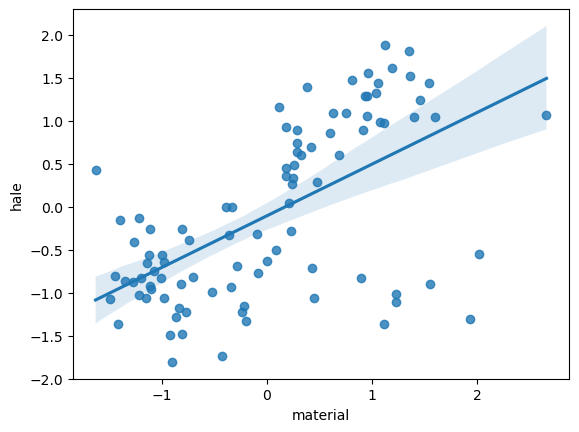

In [25]:
sns.regplot(data=regression_df_no_outliers_no_na_single, x='material', y='hale')

Looks pretty linear!

In [26]:
for y_variable in y_variables:
    for x_variable in x_variables:
        pooled_ols_single = regression_model_statsmodels(regression_df_no_outliers_no_na_single, y_variable, ['energy', x_variable], 'pooled_ols', [['energy', x_variable]])
        single_regressions.append({'model': pooled_ols_single, 'name': 'Pooled OLS Single', 'data': regression_df_no_outliers_no_na_single, 'dependent_variable': y_variable, 'independent_variables': ['energy', x_variable], 'goodness_of_fit': analyze_regression_results(pooled_ols_single, assumptions, "Pooled OLS Single")})
        pool_ols_single_linearmodels = regression_model_linearmodels(regression_df_no_outliers_no_na_single, y_variable, ['energy', x_variable], 'pooled_ols', [['energy', x_variable]])
        single_regressions.append({'model': pool_ols_single_linearmodels, 'name': 'Pooled OLS Single linearmodels', 'data': regression_df_no_outliers_no_na_single, 'dependent_variable': y_variable, 'independent_variables': ['energy', x_variable], 'goodness_of_fit': analyze_linearmodels_regression_results(pool_ols_single_linearmodels, assumptions, "Pooled OLS Single", regression_df_no_outliers_no_na_single[['energy', x_variable]])})
        fixed_effects_single = regression_model_statsmodels(regression_df_no_outliers_no_na_single, y_variable, ['energy', x_variable], 'fixed_effects', [['energy', x_variable]])
        single_regressions.append({'model': fixed_effects_single, 'name': 'Fixed Effects Single', 'data': regression_df_no_outliers_no_na_single, 'dependent_variable': y_variable, 'independent_variables': ['energy', x_variable], 'goodness_of_fit': analyze_regression_results(fixed_effects_single, assumptions, "Fixed Effects Single")})
        fixed_effects_single_linearmodels = regression_model_linearmodels(regression_df_no_outliers_no_na_single, y_variable, ['energy', x_variable], 'fixed_effects', [['energy', x_variable]])
        single_regressions.append({'model': fixed_effects_single_linearmodels, 'name': 'Fixed Effects Single linearmodels', 'data': regression_df_no_outliers_no_na_single, 'dependent_variable': y_variable, 'independent_variables': ['energy', x_variable], 'goodness_of_fit': analyze_linearmodels_regression_results(fixed_effects_single_linearmodels, assumptions, "Fixed Effects Single", regression_df_no_outliers_no_na_single[['energy', x_variable]], 'fixed_effects')})
        random_effects_single = regression_model_statsmodels(regression_df_no_outliers_no_na_single, y_variable, ['energy', x_variable], 'random_effects', [['energy', x_variable]])
        single_regressions.append({'model': random_effects_single, 'name': 'Random Effects Single', 'data': regression_df_no_outliers_no_na_single, 'dependent_variable': y_variable, 'independent_variables': ['energy', x_variable], 'goodness_of_fit': analyze_regression_results(random_effects_single, assumptions, "Random Effects Single")})
        random_effects_single_linearmodels = regression_model_linearmodels(regression_df_no_outliers_no_na_single, y_variable, ['energy', x_variable], 'random_effects', [['energy', x_variable]])
        single_regressions.append({'model': random_effects_single_linearmodels, 'name': 'Random Effects Single linearmodels', 'data': regression_df_no_outliers_no_na_single, 'dependent_variable': y_variable, 'independent_variables': ['energy', x_variable], 'goodness_of_fit': analyze_linearmodels_regression_results(random_effects_single_linearmodels, assumptions, "Random Effects Single", regression_df_no_outliers_no_na_single[['energy', x_variable]])})
# optional QQ plot
# for reg in single_provisioning_factor_regressions:
#     fig = sm.qqplot(data=reg.resid, line='45')
#     fig.suptitle('QQ plot for residuals of regression of {} on {} and {}'.format(dependent_variable, energy_variable, independent_variable))

Same for accounts data

<Axes: xlabel='material', ylabel='hale'>

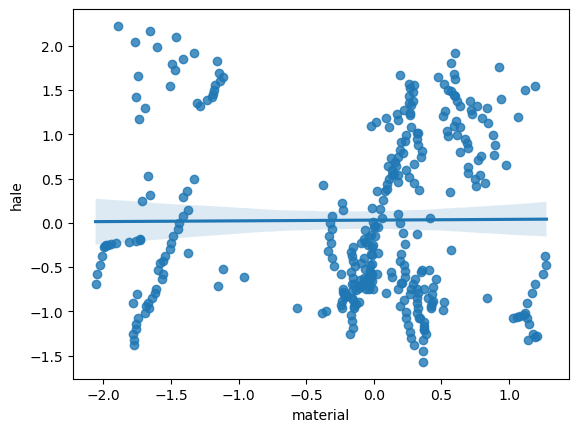

In [27]:
sns.regplot(data=regression_df_no_outliers_accounts_no_na_single, x='material', y='hale')

Again, crowded and therefore not very linear. Try filtering for year 2017.

<Axes: xlabel='material', ylabel='hale'>

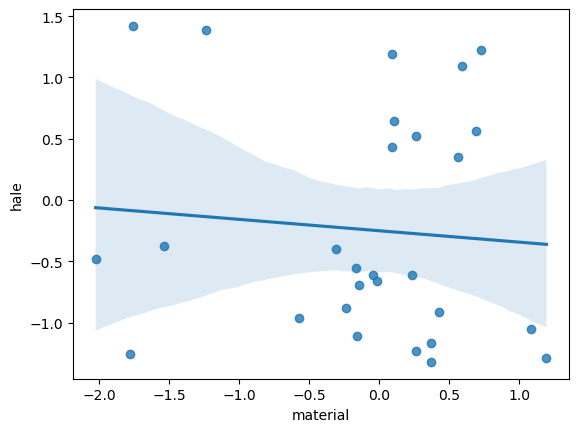

In [28]:
regression_df_no_outliers_accounts_no_na_single_2017 = regression_df_no_outliers_accounts_no_na_single[regression_df_no_outliers_accounts_no_na_single['TIME_PERIOD'] == 2017]
sns.regplot(data=regression_df_no_outliers_accounts_no_na_single_2017, x='material', y='hale')

Not quite linear for `material`! Try `providential`

<Axes: xlabel='providential', ylabel='hale'>

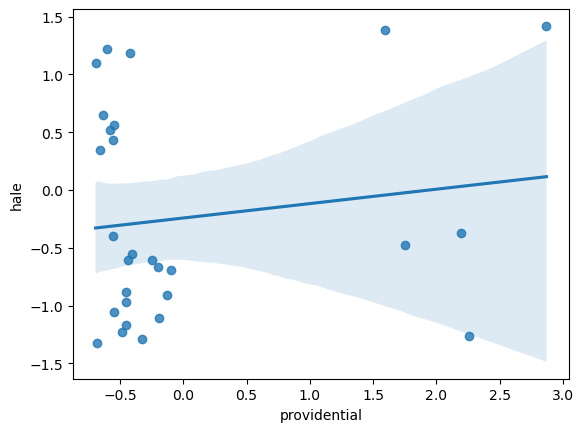

In [29]:
sns.regplot(data=regression_df_no_outliers_accounts_no_na_single_2017, x='providential', y='hale')

Might still be some outliers?

In [30]:
for y_variable in y_variables:
    for x_variable in x_variables:
        pooled_ols_single_accounts = regression_model_statsmodels(regression_df_no_outliers_accounts_no_na_single, y_variable, ['energy', x_variable], 'pooled_ols', [['energy', x_variable]])
        single_regressions_accounts.append({'model': pooled_ols_single_accounts, 'name': 'Pooled OLS Single Accounts', 'data': regression_df_no_outliers_accounts_no_na_single, 'dependent_variable': y_variable, 'independent_variables': ['energy', x_variable], 'goodness_of_fit': analyze_regression_results(pooled_ols_single_accounts, assumptions, "Pooled OLS Single")})
        pool_ols_single_linearmodels_accounts = regression_model_linearmodels(regression_df_no_outliers_accounts_no_na_single, y_variable, ['energy', x_variable], 'pooled_ols', [['energy', x_variable]])
        single_regressions_accounts.append({'model': pool_ols_single_linearmodels_accounts, 'name': 'Pooled OLS Single linearmodels Accounts', 'data': regression_df_no_outliers_accounts_no_na_single, 'dependent_variable': y_variable, 'independent_variables': ['energy', x_variable], 'goodness_of_fit': analyze_linearmodels_regression_results(pool_ols_single_linearmodels_accounts, assumptions, "Pooled OLS Single", regression_df_no_outliers_accounts_no_na_single[['energy', x_variable]])})
        fixed_effects_single_accounts = regression_model_statsmodels(regression_df_no_outliers_accounts_no_na_single, y_variable, ['energy', x_variable], 'fixed_effects', [['energy', x_variable]])
        single_regressions_accounts.append({'model': fixed_effects_single_accounts, 'name': 'Fixed Effects Single Accounts', 'data': regression_df_no_outliers_accounts_no_na_single, 'dependent_variable': y_variable, 'independent_variables': ['energy', x_variable], 'goodness_of_fit': analyze_regression_results(fixed_effects_single_accounts, assumptions, "Fixed Effects Single")})
        fixed_effects_single_linearmodels_accounts = regression_model_linearmodels(regression_df_no_outliers_accounts_no_na_single, y_variable, ['energy', x_variable], 'fixed_effects', [['energy', x_variable]])
        single_regressions_accounts.append({'model': fixed_effects_single_linearmodels_accounts, 'name': 'Fixed Effects Single linearmodels Accounts', 'data': regression_df_no_outliers_accounts_no_na_single, 'dependent_variable': y_variable, 'independent_variables': ['energy', x_variable], 'goodness_of_fit': analyze_linearmodels_regression_results(fixed_effects_single_linearmodels_accounts, assumptions, "Fixed Effects Single", regression_df_no_outliers_accounts_no_na_single[['energy', x_variable]], 'fixed_effects')})
        random_effects_single_accounts = regression_model_statsmodels(regression_df_no_outliers_accounts_no_na_single, y_variable, ['energy', x_variable], 'random_effects', [['energy', x_variable]])
        single_regressions_accounts.append({'model': random_effects_single_accounts, 'name': 'Random Effects Single Accounts', 'data': regression_df_no_outliers_accounts_no_na_single, 'dependent_variable': y_variable, 'independent_variables': ['energy', x_variable], 'goodness_of_fit': analyze_regression_results(random_effects_single_accounts, assumptions, "Random Effects Single")})
        random_effects_single_linearmodels_accounts = regression_model_linearmodels(regression_df_no_outliers_accounts_no_na_single, y_variable, ['energy', x_variable], 'random_effects', [['energy', x_variable]])
        single_regressions_accounts.append({'model': random_effects_single_linearmodels_accounts, 'name': 'Random Effects Single linearmodels Accounts', 'data': regression_df_no_outliers_accounts_no_na_single, 'dependent_variable': y_variable, 'independent_variables': ['energy', x_variable], 'goodness_of_fit': analyze_linearmodels_regression_results(random_effects_single_linearmodels_accounts, assumptions, "Random Effects Single", regression_df_no_outliers_accounts_no_na_single[['energy', x_variable]])})

### Multiple provisioning factors regressions

$$
  \widetilde{NS}_i = \hat{a} + \hat{b_1} \widetilde{ENU}_i + \hat{b_2} \widetilde{PF}_{1,i}  + \hat{b_3} \widetilde{PF}_{2,i} + \hat{b_4} \widetilde{PF}_{3,i}  + e_i
$$

Conduct a Pooled OLS regression with the following variables:
 - Dependent variable: HALE
 - Independent variables: Energy, Material, Government Effectiveness, Gini, Other

First use healthy life expectancy (hale) as the dependent variable

In [31]:
multiple_regressions = []
multiple_regressions_accounts = []

In [32]:
regression_df_no_outliers_no_na_multiple = regression_df_no_outliers.dropna(subset=['energy', 'material', 'goveffectiveness'])
regression_df_no_outliers_no_na_multiple = regression_df_no_outliers_no_na_multiple.replace([float('inf'), float('-inf')], float('nan'))
regression_df_no_outliers_accounts_no_na_multiple = regression_df_no_outliers_accounts.dropna(subset=['energy', 'material', 'goveffectiveness'])
regression_df_no_outliers_accounts_no_na_multiple = regression_df_no_outliers_accounts_no_na_multiple.replace([float('inf'), float('-inf')], float('nan'))

In [33]:
non_foundational_x_variables = ['goveffectiveness', 'gini']
x_var_combinations_3_max = []
x_var_combinations_4_max = []
for x_variable in x_variables:
    for variable in non_foundational_x_variables:
        x_var_combinations_3_max.append(['energy', x_variable, variable])
        x_var_combinations_4_max.append(['energy', x_variable, variable])
        for variable_2 in non_foundational_x_variables:
            if variable_2 != variable:
                x_var_combinations_4_max.append(['energy', x_variable, variable, variable_2])

In [34]:
for y_variable in y_variables:
    for combination in x_var_combinations_3_max:
        pooled_ols_multiple = regression_model_statsmodels(regression_df_no_outliers_no_na_multiple, y_variable, combination, 'pooled_ols')
        multiple_regressions.append({'model': pooled_ols_multiple, 'name': 'Pooled OLS Multiple', 'data': regression_df_no_outliers_no_na_multiple, 'dependent_variable': y_variable, 'independent_variables': combination, 'goodness_of_fit': analyze_regression_results(pooled_ols_multiple, assumptions, "Pooled OLS Multiple")})
        pooled_ols_multiple_linearmodels = regression_model_linearmodels(regression_df_no_outliers_no_na_multiple, y_variable, combination, 'pooled_ols')
        multiple_regressions.append({'model': pooled_ols_multiple_linearmodels, 'name': 'Pooled OLS Multiple linearmodels', 'data': regression_df_no_outliers_no_na_multiple, 'dependent_variable': y_variable, 'independent_variables': combination, 'goodness_of_fit': analyze_linearmodels_regression_results(pooled_ols_multiple_linearmodels, assumptions, "Pooled OLS Multiple", regression_df_no_outliers_no_na_multiple[combination])})
        fixed_effects_multiple = regression_model_statsmodels(regression_df_no_outliers_no_na_multiple, y_variable, combination, 'fixed_effects')
        multiple_regressions.append({'model': fixed_effects_multiple, 'name': 'Fixed Effects Multiple', 'data': regression_df_no_outliers_no_na_multiple, 'dependent_variable': y_variable, 'independent_variables': combination, 'goodness_of_fit': analyze_regression_results(fixed_effects_multiple, assumptions, "Fixed Effects Multiple")})
        fixed_effects_multiple_linearmodels = regression_model_linearmodels(regression_df_no_outliers_no_na_multiple, y_variable, combination, 'fixed_effects')
        multiple_regressions.append({'model': fixed_effects_multiple_linearmodels, 'name': 'Fixed Effects Multiple linearmodels', 'data': regression_df_no_outliers_no_na_multiple, 'dependent_variable': y_variable, 'independent_variables': combination, 'goodness_of_fit': analyze_linearmodels_regression_results(fixed_effects_multiple_linearmodels, assumptions, "Fixed Effects Multiple", regression_df_no_outliers_no_na_multiple[combination], 'fixed_effects')})
        random_effects_multiple = regression_model_statsmodels(regression_df_no_outliers_no_na_single, y_variable, combination, 'random_effects')
        multiple_regressions.append({'model': random_effects_multiple, 'name': 'Random Effects Multiple', 'data': regression_df_no_outliers_no_na_multiple, 'dependent_variable': y_variable, 'independent_variables': combination, 'goodness_of_fit': analyze_regression_results(random_effects_multiple, assumptions, "Random Effects Multiple")})
        random_effects_multiple_linearmodels = regression_model_linearmodels(regression_df_no_outliers_no_na_multiple, y_variable, combination, 'random_effects')
        multiple_regressions.append({'model': random_effects_multiple_linearmodels, 'name': 'Random Effects Multiple linearmodels', 'data': regression_df_no_outliers_no_na_multiple, 'dependent_variable': y_variable, 'independent_variables': combination, 'goodness_of_fit': analyze_linearmodels_regression_results(random_effects_multiple_linearmodels, assumptions, "Random Effects Multiple", regression_df_no_outliers_no_na_multiple[combination])})

/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/linearmodels/panel/model.py:882: MissingValueWarning:


Inputs contain missing values. Dropping rows with missing observations.

/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/linearmodels/panel/model.py:1214: MissingValueWarning:


Inputs contain missing values. Dropping rows with missing observations.

/Users/supernaturval/Documents/GitHub/provisioning-model/provisioning_model/functions/pooled_ols.py:255: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/supernaturval/Documents/GitHub/provisioning-model/provisioning_model/functions/pooled_ols.py:255: SettingWithCopyWarning:


A value is trying to be set on a copy of a slic

Same with accounts data

In [35]:
for y_variable in y_variables:
    for combination in x_var_combinations_4_max:
        pooled_ols_multiple_accounts = regression_model_statsmodels(regression_df_no_outliers_accounts_no_na_multiple, y_variable, combination, 'pooled_ols')
        multiple_regressions_accounts.append({'model': pooled_ols_multiple_accounts, 'name': 'Pooled OLS Multiple Accounts', 'data': regression_df_no_outliers_accounts_no_na_multiple, 'dependent_variable': y_variable, 'independent_variables': combination, 'goodness_of_fit': analyze_regression_results(pooled_ols_multiple_accounts, assumptions, "Pooled OLS Multiple")})
        pooled_ols_multiple_accounts_linearmodels = regression_model_linearmodels(regression_df_no_outliers_accounts_no_na_multiple, y_variable, combination, 'pooled_ols')
        multiple_regressions_accounts.append({'model': pooled_ols_multiple_accounts_linearmodels, 'name': 'Pooled OLS Multiple Accounts linearmodels', 'data': regression_df_no_outliers_accounts_no_na_multiple, 'dependent_variable': y_variable, 'independent_variables': combination, 'goodness_of_fit': analyze_linearmodels_regression_results(pooled_ols_multiple_accounts_linearmodels, assumptions, "Pooled OLS Multiple", regression_df_no_outliers_accounts_no_na_multiple[['energy', 'material', 'goveffectiveness']])})
        fixed_effects_multiple_accounts = regression_model_statsmodels(regression_df_no_outliers_accounts_no_na_multiple, y_variable, combination, 'fixed_effects')
        multiple_regressions_accounts.append({'model': fixed_effects_multiple_accounts, 'name': 'Fixed Effects Multiple Accounts', 'data': regression_df_no_outliers_accounts_no_na_multiple, 'dependent_variable': y_variable, 'independent_variables': combination, 'goodness_of_fit': analyze_regression_results(fixed_effects_multiple_accounts, assumptions, "Fixed Effects Multiple")})
        fixed_effects_multiple_accounts_linearmodels = regression_model_linearmodels(regression_df_no_outliers_accounts_no_na_multiple, y_variable, combination, 'fixed_effects')
        multiple_regressions_accounts.append({'model': fixed_effects_multiple_accounts_linearmodels, 'name': 'Fixed Effects Multiple Accounts linearmodels', 'data': regression_df_no_outliers_accounts_no_na_multiple, 'dependent_variable': y_variable, 'independent_variables': combination, 'goodness_of_fit': analyze_linearmodels_regression_results(fixed_effects_multiple_accounts_linearmodels, assumptions, "Fixed Effects Multiple", regression_df_no_outliers_accounts_no_na_multiple[['energy', 'material', 'goveffectiveness']], 'fixed_effects')})
        random_effects_multiple_accounts = regression_model_statsmodels(regression_df_no_outliers_accounts_no_na_multiple, y_variable, combination, 'random_effects')
        multiple_regressions_accounts.append({'model': random_effects_multiple_accounts, 'name': 'Random Effects Multiple Accounts', 'data': regression_df_no_outliers_accounts_no_na_multiple, 'dependent_variable': y_variable, 'independent_variables': combination, 'goodness_of_fit': analyze_regression_results(random_effects_multiple_accounts, assumptions, "Random Effects Multiple")})
        random_effects_multiple_accounts_linearmodels = regression_model_linearmodels(regression_df_no_outliers_accounts_no_na_multiple, y_variable, combination, 'random_effects')
        multiple_regressions_accounts.append({'model': random_effects_multiple_accounts_linearmodels, 'name': 'Random Effects Multiple Accounts linearmodels', 'data': regression_df_no_outliers_accounts_no_na_multiple, 'dependent_variable': y_variable, 'independent_variables': combination, 'goodness_of_fit': analyze_linearmodels_regression_results(random_effects_multiple_accounts_linearmodels, assumptions, "Random Effects Multiple", regression_df_no_outliers_accounts_no_na_multiple[['energy', 'material', 'goveffectiveness']])})

/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/linearmodels/panel/model.py:882: MissingValueWarning:


Inputs contain missing values. Dropping rows with missing observations.



/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/linearmodels/panel/model.py:1214: MissingValueWarning:


Inputs contain missing values. Dropping rows with missing observations.

/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/linearmodels/panel/model.py:2618: MissingValueWarning:


Inputs contain missing values. Dropping rows with missing observations.

/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/linearmodels/panel/model.py:882: MissingValueWarning:


Inputs contain missing values. Dropping rows with missing observations.

/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/linearmodels/panel/model.py:1214: MissingValueWarning:


Inputs contain missing values. Dropping rows with missing observations.

/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/linearmodels/panel/model.py:2618: MissingValueWarning:


Inpu

Usually a rule of thumb is to have at least 10-15 observations per parameter. In our case, with 140 observations and 37 parameters, we have approximately 140/37 ≈ 3.78 observations per parameter, which is below this threshold.

A way to address this is to have more time periods     
For a 10:1 ratio: need at least 10 observations per parameter. With 37 parameters, this equates to $37×10=37037×10=370$ total observations. With our 35 countries, this means we need approximately $37035≈10.635370​≈10.6$ time periods.

For a 15:1 ratio: need 15 observations per parameter. This equates to $37×15=55537×15=555$ total observations. With 35 countries, this would be approximately $55535≈15.935555​≈15.9$ time periods.

Accounts data should have enough observations to include up to 3-4 independent variables

Conduct the F-test for fixed effects

First one is Pooled OLS, second is Fixed Effects, third is Random Effects.
The r squared and log likelihood looks better for fixed effects compared to random effects. 
But the AIC is better (lower) for random effects as compared to fixed.
Are some assumptions are still violated?

Export the regression results to use in the plotting notebook

In [36]:
%store bivariate_regressions
%store bivariate_regressions_accounts
%store single_regressions
%store single_regressions_accounts
%store multiple_regressions
%store multiple_regressions_accounts

Stored 'bivariate_regressions' (list)
Stored 'bivariate_regressions_accounts' (list)
Stored 'single_regressions' (list)
Stored 'single_regressions_accounts' (list)
Stored 'multiple_regressions' (list)
Stored 'multiple_regressions_accounts' (list)


## Regression by sector (Later)
 - Use sectoral energy input (per cap? share?), sectoral labor share and sector-related need satisfaction variable

## Regression by region (Later)
 - Use total regional energy input (per cap? share?), total regional labor share and total regional need satisfaction variable

**Note**: We're not doing a fourth set of 
regressions by region + input due to data availability. Maybe in future research

## Misc/removed for now

In [37]:
# import scipy.stats as st
# ssr_restricted_model = hale_results.ssr
# ssr_unrestricted_model = fixed_effects_results[0].ssr
# k1 = len(hale_results.params)
# k2 = len(fixed_effects_results[0].params)
# f_statistic = ((ssr_restricted_model - ssr_unrestricted_model) /ssr_unrestricted_model) * ((N-k2)/(k2-k1))
# print('F-statistic for FE model='+str(f_statistic))
# alpha=0.05
# f_critical_value=st.f.ppf((1.0-alpha), (k2-k1), (N-k2))
# print('F test critical value at alpha of 0.05='+str(f_critical_value))

F-statistic is much higher than critical value, so we reject the null hypothesis that the restricted model is better than the unrestricted model. The fixed effects model is better than the pooled OLS model.

In [38]:
#Concatenate the unit names column to the Dataframe containing the residuals from the Pooled OLSR model
# df_pooled_olsr_resid_with_unitnames = pd.concat([regression_df_no_outliers['geo'],hale_results.resid], axis=1)
# df_pooled_olsr_resid_group_means = df_pooled_olsr_resid_with_unitnames.groupby('geo').mean()
# ssr_grouped_means=(df_pooled_olsr_resid_group_means[0]**2).sum()
# ssr_pooled_olsr=hale_results.ssr
# LM_statistic = (n*T)/(2*(T-1))*math.pow(((T*T*ssr_grouped_means)/ssr_pooled_olsr - 1),2)

# print('BP LM Statistic='+str(LM_statistic))

LM statistic is much higher than critical value, which means random effect is significant.

In [39]:
# alpha=0.05
# chi2_critical_value=st.chi2.ppf((1.0-alpha), 1)
# print('chi2_critical_value='+str(chi2_critical_value))